In [1]:
import pandas as pd
import numpy as np 
import datetime
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import History
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# Data

Date      datetime64[ns]
Period             int64
Value            float64
dtype: object


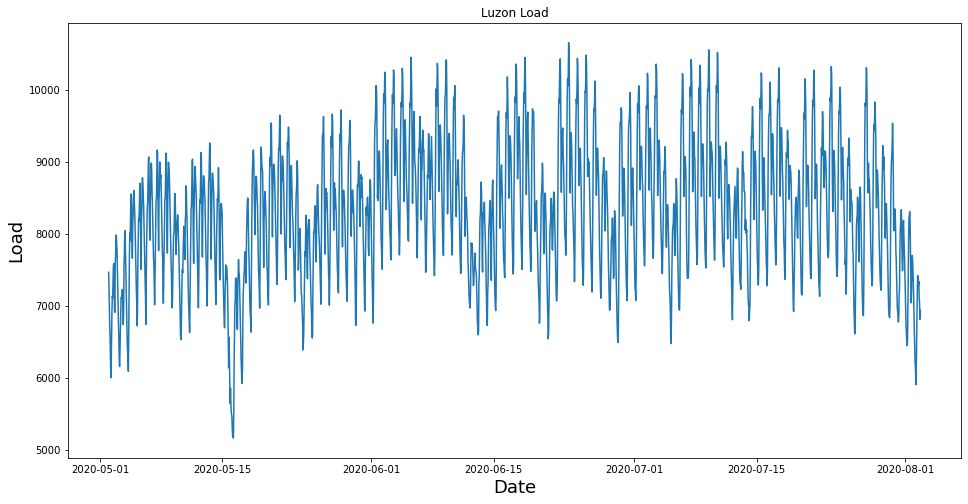

,Date,Period,Value,month,day,quarter,dayofweek,dayofweek_name,is_weekend
Date,,,,,,,,,
2020-05-02 00:00:00,2020-05-02 00:00:00,1,7466.0,5,2,2,5,Saturday,1
2020-05-02 01:00:00,2020-05-02 01:00:00,2,7238.1,5,2,2,5,Saturday,1
2020-05-02 02:00:00,2020-05-02 02:00:00,3,6934.5,5,2,2,5,Saturday,1
2020-05-02 03:00:00,2020-05-02 03:00:00,4,6706.9,5,2,2,5,Saturday,1
2020-05-02 04:00:00,2020-05-02 04:00:00,5,6555.9,5,2,2,5,Saturday,1
...,...,...,...,...,...,...,...,...,...
2020-08-02 13:00:00,2020-08-02 13:00:00,14,7340.2,8,2,3,6,Sunday,1
2020-08-02 14:00:00,2020-08-02 14:00:00,15,7115.1,8,2,3,6,Sunday,1
2020-08-02 15:00:00,2020-08-02 15:00:00,16,7032.0,8,2,3,6,Sunday,1


In [2]:
data = pd.read_csv('4-Volume.csv')
# convert the data type of the column to DateTime
data['Date']= pd.to_datetime(data['Date']) 
print(data.dtypes)

data['month'] = data['Date'].dt.month
data['day'] = data['Date'].dt.day
data['quarter'] = data['Date'].dt.quarter
# data['semester'] = np.where(data.quarter.isin([1,2]),1,2)
data['dayofweek'] = data['Date'].dt.dayofweek
data['dayofweek_name'] = data['Date'].dt.day_name()
data['is_weekend'] = np.where(data['dayofweek_name'].isin(['Sunday','Saturday']),1,0)

data['Date'] = pd.to_datetime(data.Date, format='%Y-%m-%d')
data.index = data['Date']

plt.figure(figsize=(16, 8))
plt.title('Luzon Load')
plt.plot(data['Value'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Load', fontsize=18)
plt.show()

data

## Data for a Specific Period

In [3]:
# extract data for each period --> period 18
data_split = data#.loc[data['Period'] == 18]
data_split

,Date,Period,Value,month,day,quarter,dayofweek,dayofweek_name,is_weekend
Date,,,,,,,,,
2020-05-02 00:00:00,2020-05-02 00:00:00,1,7466.0,5,2,2,5,Saturday,1
2020-05-02 01:00:00,2020-05-02 01:00:00,2,7238.1,5,2,2,5,Saturday,1
2020-05-02 02:00:00,2020-05-02 02:00:00,3,6934.5,5,2,2,5,Saturday,1
2020-05-02 03:00:00,2020-05-02 03:00:00,4,6706.9,5,2,2,5,Saturday,1
2020-05-02 04:00:00,2020-05-02 04:00:00,5,6555.9,5,2,2,5,Saturday,1
...,...,...,...,...,...,...,...,...,...
2020-08-02 13:00:00,2020-08-02 13:00:00,14,7340.2,8,2,3,6,Sunday,1
2020-08-02 14:00:00,2020-08-02 14:00:00,15,7115.1,8,2,3,6,Sunday,1
2020-08-02 15:00:00,2020-08-02 15:00:00,16,7032.0,8,2,3,6,Sunday,1


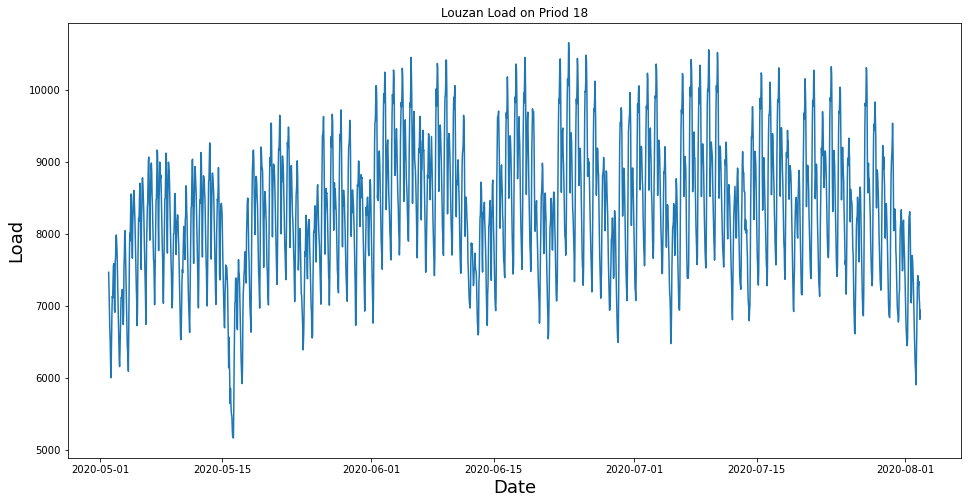

In [4]:
plt.figure(figsize=(16, 8))
plt.title('Louzan Load on Priod 18')
plt.plot(data_split['Value'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Load', fontsize=18)
plt.show()

# Data Preparation

split data to train and test by date 2020-07-27

In [5]:
data_train = data_split.loc[data_split["Date"] <= "2020-07-27"]
data_test = data_split.loc[data_split["Date"] > "2020-07-27"]
data_test

,Date,Period,Value,month,day,quarter,dayofweek,dayofweek_name,is_weekend
Date,,,,,,,,,
2020-07-27 01:00:00,2020-07-27 01:00:00,2,7380.3,7,27,3,0,Monday,0
2020-07-27 02:00:00,2020-07-27 02:00:00,3,7159.0,7,27,3,0,Monday,0
2020-07-27 03:00:00,2020-07-27 03:00:00,4,6995.6,7,27,3,0,Monday,0
2020-07-27 04:00:00,2020-07-27 04:00:00,5,6887.5,7,27,3,0,Monday,0
2020-07-27 05:00:00,2020-07-27 05:00:00,6,6863.7,7,27,3,0,Monday,0
...,...,...,...,...,...,...,...,...,...
2020-08-02 13:00:00,2020-08-02 13:00:00,14,7340.2,8,2,3,6,Sunday,1
2020-08-02 14:00:00,2020-08-02 14:00:00,15,7115.1,8,2,3,6,Sunday,1
2020-08-02 15:00:00,2020-08-02 15:00:00,16,7032.0,8,2,3,6,Sunday,1


In [6]:
# put you feature data to x_data
n_features = 2
x_train = array(data_train[['Period', 'dayofweek']])
x_test = array(data_test[['Period', 'dayofweek']])
y_train = array(data_train[['Value']])
y_test = array(data_test[['Value']])
#x_train

In [7]:
# multivariate data preparation
from numpy import array
from numpy import hstack

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


In [8]:
# convert to [rows, columns] structure
x_train = x_train.reshape((len(x_train), n_features))
x_test = x_test.reshape((len(x_test), n_features))
y_train = y_train.reshape((len(y_train), 1))
y_test = y_test.reshape((len(y_test), 1))

#x_test

In [9]:
# horizontally stack columns
dataset_train = hstack((x_train, y_train))

dataset_test = hstack((x_test, y_test))
# choose a number of time steps
# dataset_test

In [10]:
n_steps = 24
# convert into input/output
X_train, y_train = split_sequences(dataset_train, n_steps)
X_test, y_test = split_sequences(dataset_test, n_steps)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
# summarize the data
# for i in range(len(X_train)):
#     print(X_train[i], y_train[i])

(2042, 24, 2) (2042,)
(138, 24, 2) (138,)


In [11]:
# define model
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_percentage_error'])

# fit model
model.fit(X_train, y_train, epochs=200, verbose=1, batch_size = 24)

Epoch 1/200
2042/2042 [==============================] - 2s 1ms/step - loss: 28293784.7414 - mean_absolute_percentage_error: 49.3252
Epoch 2/200
2042/2042 [==============================] - 2s 751us/step - loss: 10200455.7718 - mean_absolute_percentage_error: 27.7310
Epoch 3/200
2042/2042 [==============================] - 2s 737us/step - loss: 5078299.0274 - mean_absolute_percentage_error: 20.6623
Epoch 4/200
2042/2042 [==============================] - 1s 674us/step - loss: 2045378.8432 - mean_absolute_percentage_error: 12.5799
Epoch 5/200
2042/2042 [==============================] - 1s 666us/step - loss: 582823.6543 - mean_absolute_percentage_error: 7.5319
Epoch 6/200
2042/2042 [==============================] - 1s 667us/step - loss: 451615.9378 - mean_absolute_percentage_error: 6.5473
Epoch 7/200
2042/2042 [==============================] - 1s 674us/step - loss: 422725.9216 - mean_absolute_percentage_error: 6.2475
Epoch 8/200
2042/2042 [==============================] - 1s 726us/st

2042/2042 [==============================] - 2s 892us/step - loss: 427026.7331 - mean_absolute_percentage_error: 6.2390
Epoch 60/200
2042/2042 [==============================] - 2s 879us/step - loss: 410211.6706 - mean_absolute_percentage_error: 6.1249
Epoch 61/200
2042/2042 [==============================] - 2s 982us/step - loss: 400981.9095 - mean_absolute_percentage_error: 6.0537
Epoch 62/200
2042/2042 [==============================] - 2s 976us/step - loss: 366881.6658 - mean_absolute_percentage_error: 5.7422
Epoch 63/200
2042/2042 [==============================] - 2s 968us/step - loss: 391521.1204 - mean_absolute_percentage_error: 5.9060
Epoch 64/200
2042/2042 [==============================] - 2s 971us/step - loss: 377798.8996 - mean_absolute_percentage_error: 5.8434
Epoch 65/200
2042/2042 [==============================] - 2s 965us/step - loss: 398928.7548 - mean_absolute_percentage_error: 5.9579
Epoch 66/200
2042/2042 [==============================] - 2s 978us/step - loss: 35

2042/2042 [==============================] - 2s 780us/step - loss: 339292.1224 - mean_absolute_percentage_error: 5.4156
Epoch 120/200
2042/2042 [==============================] - 2s 821us/step - loss: 335095.9163 - mean_absolute_percentage_error: 5.3537
Epoch 121/200
2042/2042 [==============================] - 1s 722us/step - loss: 303543.9625 - mean_absolute_percentage_error: 5.1280
Epoch 122/200
2042/2042 [==============================] - 1s 721us/step - loss: 343614.0197 - mean_absolute_percentage_error: 5.4196
Epoch 123/200
2042/2042 [==============================] - 2s 771us/step - loss: 307036.9138 - mean_absolute_percentage_error: 5.1338
Epoch 124/200
2042/2042 [==============================] - 2s 748us/step - loss: 345944.9618 - mean_absolute_percentage_error: 5.4714
Epoch 125/200
2042/2042 [==============================] - 2s 745us/step - loss: 299157.6217 - mean_absolute_percentage_error: 5.0968
Epoch 126/200
2042/2042 [==============================] - 2s 744us/step - l

2042/2042 [==============================] - 2s 777us/step - loss: 314307.0494 - mean_absolute_percentage_error: 5.1110
Epoch 178/200
2042/2042 [==============================] - 2s 831us/step - loss: 305709.0076 - mean_absolute_percentage_error: 5.0580
Epoch 179/200
2042/2042 [==============================] - 2s 754us/step - loss: 311215.3079 - mean_absolute_percentage_error: 5.1403
Epoch 180/200
2042/2042 [==============================] - 1s 733us/step - loss: 322441.5083 - mean_absolute_percentage_error: 5.2761
Epoch 181/200
2042/2042 [==============================] - 2s 758us/step - loss: 349139.8114 - mean_absolute_percentage_error: 5.5078
Epoch 182/200
2042/2042 [==============================] - 2s 802us/step - loss: 319069.5843 - mean_absolute_percentage_error: 5.1841
Epoch 183/200
2042/2042 [==============================] - 2s 758us/step - loss: 301711.6474 - mean_absolute_percentage_error: 5.0339 0s - loss: 280397.0770 - mean_absolute_percenta
Epoch 184/200
2042/2042 [===

In [12]:
# demonstrate prediction
y_test_hat = model.predict(X_test, verbose=0)
y_test = list(y_test)
for i in range(len(y_test_hat)):
    print(y_test_hat[i]-y_test[i])

[-243.04297]
[-168.80566]
[-170.07178]
[-75.288086]
[-177.69531]
[-109.17432]
[68.36035]
[-301.14355]
[-413.38184]
[-485.5537]
[-263.21094]
[128.25]
[-180.78711]
[-183.06348]
[26.230469]
[-123.125]
[-26.05371]
[-253.18457]
[-68.118164]
[-52.33789]
[260.95996]
[455.99512]
[417.3838]
[114.44238]
[232.88037]
[179.1499]
[186.52002]
[130.97607]
[68.958496]
[153.50244]
[344.9668]
[180.1416]
[105.42383]
[202.84961]
[167.04883]
[674.42676]
[669.8135]
[705.63086]
[938.584]
[671.4922]
[571.3345]
[250.8628]
[335.04883]
[550.1465]
[685.10156]
[950.6406]
[1052.0098]
[762.4497]
[844.44824]
[816.271]
[866.68994]
[803.0957]
[612.1084]
[636.688]
[671.6499]
[544.0215]
[181.57715]
[148.6289]
[308.08594]
[539.0449]
[227.62012]
[164.02637]
[400.76465]
[417.9336]
[536.6499]
[83.83887]
[452.3203]
[537.8721]
[758.33887]
[920.6494]
[1062.7075]
[877.4385]
[852.72314]
[830.87646]
[823.4155]
[672.02246]
[543.6455]
[562.5283]
[647.1094]
[681.14355]
[1046.5815]
[955.03125]
[984.9961]
[1215.0337]
[997.8613]
[1097.77

# Implement MAPE

In [13]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

MAPE =mean_absolute_percentage_error(y_test, y_test_hat)
MAPE

13.857280207956546

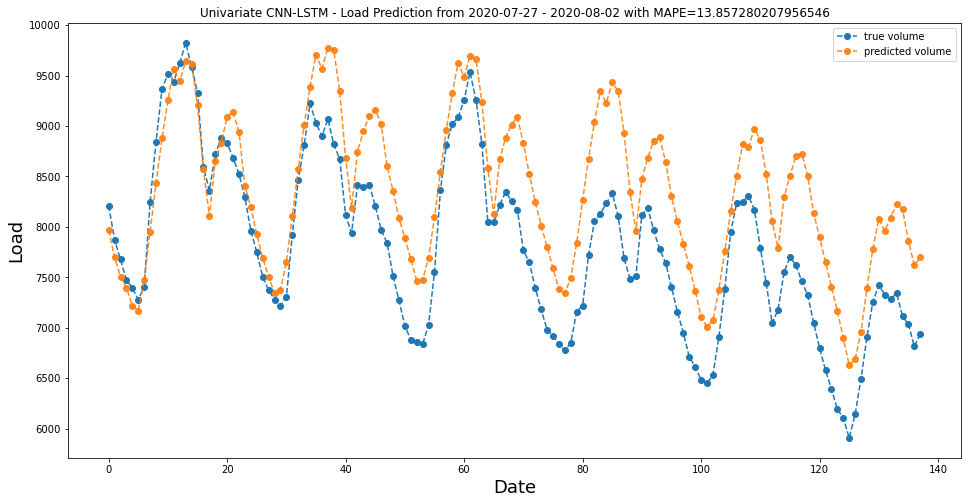

In [14]:
plt.figure(figsize=(16, 8))
plt.title('Univariate CNN-LSTM - Load Prediction from 2020-07-27 - 2020-08-02 with MAPE='+ str(MAPE))
plt.plot(y_test, 'o--', alpha=1)
plt.plot(y_test_hat, 'o--', alpha=0.9)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Load', fontsize=18)
plt.legend(['true volume', 'predicted volume'], loc='upper right')

plt.show()


# Visuliza Model + RMSE + Weights

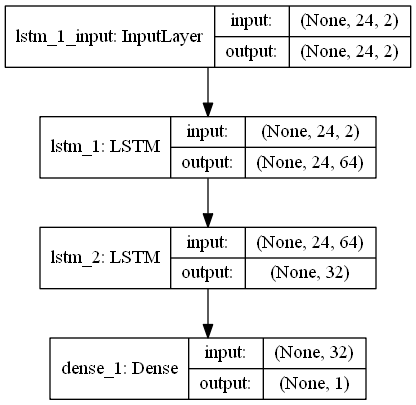

In [15]:
from keras.utils.vis_utils import plot_model
# pip install pydot
# conda install python-graphviz

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [16]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

RMSE=measure_rmse(y_test, y_test_hat)
RMSE

682.5091136575192

In [17]:
for layer in model.layers:
    weights = layer.get_weights() 
    
weights

[array([[ 0.19838473],
        [-0.38897565],
        [-0.03627512],
        [-0.3983533 ],
        [ 0.11866242],
        [-0.06945122],
        [-0.15368298],
        [-0.36948916],
        [-0.28129998],
        [ 0.26411855],
        [ 0.00081481],
        [ 0.17406236],
        [ 0.20059562],
        [ 0.15482722],
        [ 0.436971  ],
        [-0.18279257],
        [ 0.2263356 ],
        [ 0.04415534],
        [-0.0127388 ],
        [-0.17738804],
        [-0.13214645],
        [ 0.35371247],
        [ 0.3891056 ],
        [-0.3429086 ],
        [ 0.05840709],
        [ 0.09082276],
        [-0.08566894],
        [ 0.37126255],
        [ 0.14357178],
        [-0.38021034],
        [-0.04639104],
        [-0.21644115]], dtype=float32),
 array([0.41985554], dtype=float32)]